# COMP 204 - Assignment #5

**Due date:** Friday, April 12, 23:59

**What to submit:** This Jupyter notebook,with code completed for each question

**Background:** Predicting IDC in Breast Cancer Histology Images

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer.  Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

In this assignment, we will use machine learning approach to identify IDC when it is present in otherwise unlabeled histopathology images.  The dataset consists of approximately five thousand 50x50 pixel RGB digital images of color stained breast histopathology samples that are labeled as either IDC or non-IDC. 

For easy importing, the digital images are extracted from breast tissue samples and saved as numpy arrays. Each image patch is a 50x50x3 image with 3 color channels representing red, blue and green (RBG). Therefore, The breast tissue contains many cells but only some of them are cancerous.  Images that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma.

The questions to answer in this assignment are summarized as follows:

Total 100 points plus 10 points from the bonus question:

* Q1 (10 points): create training and testing
* Q2 (20 points): evaluate logistic regression (overfitting detected)
* Q3 (10 points): principal component analysis to reduce 7500 features to 10 PCs
* Q4 (10 points): run LR on PCA-transformed data
* Q5 (20 points): 5-fold cross-validation and ROC curve on LR with and without PCA transformation (I thought them ROC and CV in class in lecture 31 with example code).
* Q6 (30 points): Method comparison 5-fold CV on 5 different methods with and without PCA (i.e, 10 methods to compare) and draw ROC curve.
* Bonus (10 bonus): run convolutional neural network on the full 5000 imaging data


**NOTE**: Due to random split and model initialization (where the random seed differ from one system (e.g., Windows) to anotehr system (e.g., a Mac), the answers you obtain may be slightly different from the expected outputs indicated below each question. Nonetheless, the results should be very close and qualitatively the same. 

First, let's import all of the required modules

NOTE: you will need to install all of the modules if you have not done so already via Anaconda Navigator: environment -> all, then search the module name that you want to install.

or install them via Anaconda Prompt:

conda install [module name]

In [1]:
# imports
import numpy as np
from matplotlib import pyplot
import matplotlib.pylab as plt
from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import random 

For the purpose of this assignment, unless mentioned otherwise, we will be working with only **500** out of the 5000 labelled images. The following code snippet (commented out on purpose) subsamples randomly 500 samples and saves it in the data directory. 

DO NOT RUN THIS block but rather using the file A5_X.npy and A5_Y.npy that are provided to you in this assignment.

In [2]:
# X = np.load('X.npy') # images
# Y = np.load('Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)
# random.seed(9001)
# idx = np.array(random.sample(range(Y.shape[0]), 500))
# X = X[idx] / 256.0 # normalize the data within range 0 and 1
# Y = Y[idx]

# np.save('A5_X.npy',X)
# np.save('A5_Y.npy',Y)

Load the subsampled image and label data

In [3]:
X = np.load('A5_X.npy') # images
Y = np.load('A5_Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

We can print some simple statistics of the data as follows

In [4]:
print('Total number of images: {}'.format(len(X)))
print('Number of IDC(-) Images: {}'.format(np.sum(Y==0)))
print('Number of IDC(+) Images: {}'.format(np.sum(Y==1)))
print('Percentage of IDC(+) images: {:.2f}%'.format(100*np.mean(Y)))
print('Image shape (Width, Height, Channels): {}'.format(X[0].shape))

Total number of images: 500
Number of IDC(-) Images: 235
Number of IDC(+) Images: 265
Percentage of IDC(+) images: 53.00%
Image shape (Width, Height, Channels): (50, 50, 3)


We can visiualize the image data as follows. Can you notice the distinct patterns between IDC(-) and IDC(+) samples?

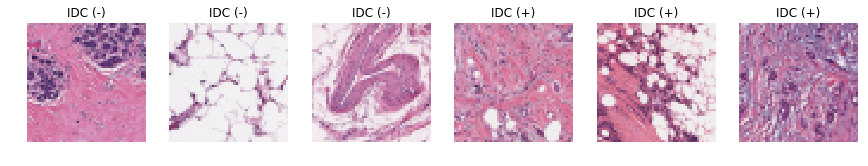

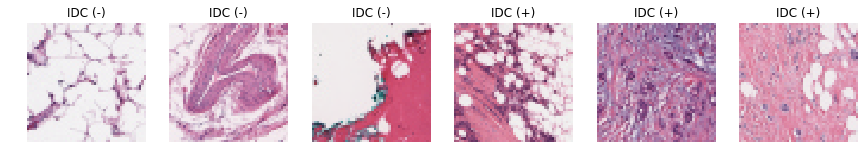

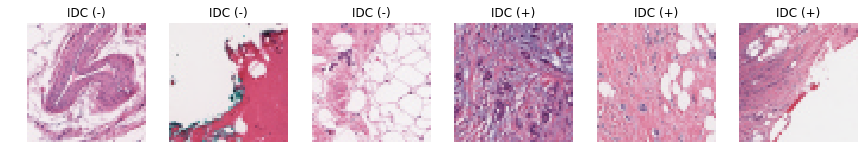

In [5]:
def plotImg(X0,X1):
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3): # plot 3 IDC(-) and 3 IDC(+) in one row
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(X0[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(X1[row+col])
            plt.axis('off')
            
plotImg(X[Y==0], X[Y==1])

The machine learning methods we are using are not capable of operating on two-dimensional color images (i.e., 3D numpy array). 

To make them applicable to our data, we will need to **flatten** the image to represent them as 1D features

DO NOT MODIFY THIS BLOCK OF CODE OTHERWISE YOUR RESULTS WILL NOT BE CORRECT

In [6]:
X_shape = X.shape[1]*X.shape[2]*X.shape[3]

X_flat = X.reshape(X.shape[0], X_shape)

X_flat.shape

(500, 7500)

This gives us a 500 x 7500 array with 500 images of 7500 features (i.e., $50 \times 50 \times 3 = 7500$)

**Question 1 (10 points) Create training and testing**

First, split the data into 80% training and 20% testing set

In [7]:
# train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y, test_size=0.20)

print("Training Data Shape:", X_train.shape, Y_train.shape)
print("Testing Data Shape:", X_test.shape, Y_test.shape)

Training Data Shape: (400, 7500) (400,)
Testing Data Shape: (100, 7500) (100,)


This should output:

Training Data Shape: (400, 7500) (400,)<br>
Testing Data Shape: (100, 7500) (100,)

**Question 2 (20 points) Train and evaluate logistic regression classifier**

Next, write a function evaluateAccuracy_LR to evaluate the accuracy of logistic regression (LR) classifier.

You will use the training set (i.e., 80% of dataset) to train the LR classifer and use the testing set (i.e., 20% of the dataset) to evaluate your trained LR model.

In [8]:
#runLogisticRegression
def evaluateAccuracy_LR(train_x, train_y, test_x, test_y): 

    logmodel = LogisticRegression()
    logmodel.fit(train_x,train_y)
    
    predictions = logmodel.predict(test_x)
    redundant = logmodel.predict(train_x)
    
    # scores for testing set accuracy
    fpr_test, tpr_test, thresholds = roc_curve(test_y,predictions)
    acc_test = roc_auc_score(test_y, predictions)
    
    # scores for training set accuracy
    fpr_train, tpr_train, thresholds = roc_curve(train_y,redundant)
    acc_train = roc_auc_score(train_y, redundant)
    
    return acc_train,tpr_train[1],fpr_train[1],acc_test,tpr_test[1],fpr_test[1]

In [9]:
acc_train,tpr_train,fpr_train,acc_test,tpr_test,fpr_test = evaluateAccuracy_LR(X_train, Y_train, X_test, Y_test)

print(f"Train: accuracy: {acc_train:.2}, TPR: {tpr_train:.2}, FPR: {fpr_train:.2}")
print(f"Testing: accuracy: {acc_test:.2}, TPR: {tpr_test:.2}, FPR: {fpr_test:.2}")

/Users/charlielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train: accuracy: 1.0, TPR: 1.0, FPR: 0.0
Testing: accuracy: 0.72, TPR: 0.73, FPR: 0.29


This should output:

Train: accuracy: 1.0, TPR: 1.0, FPR: 0.0<br>
Testing: accuracy: 0.71, TPR: 0.66, FPR: 0.23

*NOTE*: you may not get exactly the same numbers as the one shown above because of the random split and initialization of the LR model. But your answer should be qualitatively similar

As we can see above, we obtained perfect training performance and much worse testing performance. This implies a severe overfitting of the data.

**Dimensional reduction**


We have 7500 features for only 500 training examples. Even if we use the full 5000 examples, the number of examples is still lower than the number of features. This is commonly known as the "curse of dimensionality", which in some sense implies that models like logistic regression (without successful sparse regularization) will be doomed to overfit the data.

To address this issue, we will use an _a priori_ feature selection technique called ***Principal Component Analysis*** (PCA) that reduces the dimensionality of the problem. PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. We first find the direction in which the data varies the most. We set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. The diagram illustrates this process. There are as many principal components as the feature dimension: all we have done is a rotation.

We'll reduce our dimensionality from 7500 to **10** principal components (PCs).

![pcanim](pcanim.gif)

(diagram taken from http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues which also has nice discussions)

Run the following code to transform the $500\times 7500$ input data to $500\times10$ data with 10 PCs

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_flat)
X_pca = pca.transform(X_flat)
X_pca.shape

(500, 10)

We can examine how much total variance the 10 PCs explain:

In [11]:
pca.explained_variance_ratio_.sum()

0.6043094330763528

In total, 10 PCs can explain 60% of the total variance, which is sufficient for our purpose.

Also, we can examine how much variance each PC explains:

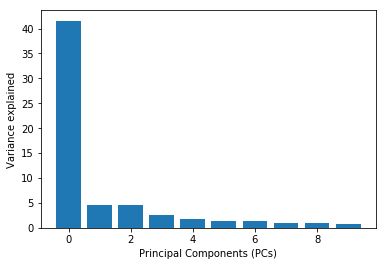

In [12]:
plt.bar(range(10), pca.explained_variance_ratio_*100)
plt.xlabel("Principal Components (PCs)")
plt.ylabel("Variance explained")
plt.show()

From the above bar plot, we see that the first three PC explain substantially more variance than the rest of the 7 PCs.

***Question 3 (10 points) apply PCA to training and testing sets***

Re-train the PCA ONLY on the training data set and then apply the trained PCA to transform both the training and testing data sets.

In [13]:
# PCA transform
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)
print(X_train_PCA.shape)
print(X_test_PCA.shape)

#X_train_PCA = pca.transform(X_train)
#X_test_PCA = pca.transform(X_test)
#print(X_train_PCA.shape)
#print(X_test_PCA.shape)

(400, 10)
(100, 10)


In [14]:
# 3dPlot array preprocessing, appending first, second and third principal components

"""
xsTrain = []
ysTrain = []
zsTrain = []
xsTest = []
ysTest = []
zsTest = []
for i in X_train_PCA:
    xsTrain.append(i[0])
for i in X_train_PCA:
    ysTrain.append(i[1])
for i in X_train_PCA:
    zsTrain.append(i[2])
for i in X_test_PCA:
    xsTest.append(i[0])
for i in X_test_PCA:
    ysTest.append(i[1])
for i in X_test_PCA:
    zsTest.append(i[2])
    
xsTrain = np.array(xsTrain)
ysTrain = np.array(ysTrain)
zsTrain = np.array(zsTrain)
xsTest = np.array(xsTest)
ysTest = np.array(ysTest)
zsTest = np.array(zsTest)

"""

'\nxsTrain = []\nysTrain = []\nzsTrain = []\nxsTest = []\nysTest = []\nzsTest = []\nfor i in X_train_PCA:\n    xsTrain.append(i[0])\nfor i in X_train_PCA:\n    ysTrain.append(i[1])\nfor i in X_train_PCA:\n    zsTrain.append(i[2])\nfor i in X_test_PCA:\n    xsTest.append(i[0])\nfor i in X_test_PCA:\n    ysTest.append(i[1])\nfor i in X_test_PCA:\n    zsTest.append(i[2])\n    \nxsTrain = np.array(xsTrain)\nysTrain = np.array(ysTrain)\nzsTrain = np.array(zsTrain)\nxsTest = np.array(xsTest)\nysTest = np.array(ysTest)\nzsTest = np.array(zsTest)\n\n'

Plot the first three PCs in a three-dimensional scatter plot with PC1 in x-axis, PC2 in y-axis, and PC3 in z-axis. Visualize the data points by coloring the IDC(+) in red and IDC(-) in blue. Use circle 'o' to represent training data points and 'x' to represent testing data points.

Learn how to generate 3D scatter plot here (https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html)

Text(0.5,0,'PC3')

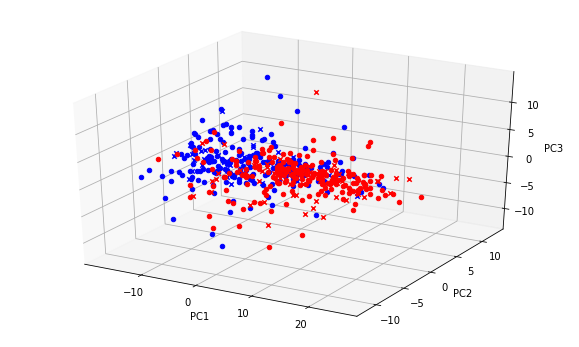

In [15]:
# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,6))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')

ax.scatter(X_train_PCA[:,0][Y_train==0],X_train_PCA[:,1][Y_train==0],X_train_PCA[:,2][Y_train==0], c='b', marker='o', depthshade=False)
ax.scatter(X_train_PCA[:,0][Y_train==1],X_train_PCA[:,1][Y_train==1],X_train_PCA[:,2][Y_train==1], c='r', marker='o', depthshade=False)
ax.scatter(X_test_PCA[:,0][Y_test==0],X_test_PCA[:,1][Y_test==0],X_test_PCA[:,2][Y_test==0], c='b', marker='x', depthshade=False)
ax.scatter(X_test_PCA[:,0][Y_test==1],X_test_PCA[:,1][Y_test==1],X_test_PCA[:,2][Y_test==1], c='r', marker='x', depthshade=False)

#ax.scatter(xsTrain, ysTrain, zsTrain, marker='o', c=Y_train)
#ax.scatter(xsTest, ysTest, zsTest, marker='x', c=Y_test)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

The expected plot is shown below

![title](pca.png)

**Question 4 (10 points) Evaluate the logistic regression using the 10 PCs**

In [16]:
acc_train,tpr_train,fpr_train,acc_test,tpr_test,fpr_test = evaluateAccuracy_LR(X_train_PCA, Y_train, X_test_PCA, Y_test)

print(f"Train: accuracy: {acc_train:.2}, TPR: {tpr_train:.2}, FPR: {fpr_train:.2}")
print(f"Testing: accuracy: {acc_test:.2}, TPR: {tpr_test:.2}, FPR: {fpr_test:.2}")

Train: accuracy: 0.77, TPR: 0.74, FPR: 0.2
Testing: accuracy: 0.75, TPR: 0.69, FPR: 0.18


/Users/charlielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The expected outputs are (once again your results may differ slightly due to the random split and model initialization):

Train: accuracy: 0.77, TPR: 0.77, FPR: 0.22<br>
Testing: accuracy: 0.78, TPR: 0.75, FPR: 0.18

We see a much better performance on the testing set and also no obvious overfitting occurs after the PCA dimensionality reduction!

**Question 5 (20 points) Five-fold Cross Validation**

As we discussed in Lecture 31, instead of evaluting the model only on the 20% of data, we want to evaluate the model on ALL of the data points. Implement a 5-fold cross-validation to evaluate the model as follows:

1. Divide the dataset into 5 folds
2. Train a PCA model on 4 folds
3. Train a LR model on the PCA-transformed 4 folds
4. Apply the trained 10-component PCA model to transform the held-out fold
5. Apply the LR to the PCA-transformed held-out fold. Save the probabilities of the model predictions
6. Repeat 2-5 steps on each fold (i.e.,  5 times in total)
7. Generate a ROC curve on ALL of the predictions over the 5 folds
8. Calculate the AUC from the ROC curve.

For comparison, also implement the same 5-fold CV using the LR model operating on the _untransformed_ 7500-features data as follows:

1. Divide the dataset into 5 folds
2. Train a LR model on 4 folds
3. Apply the LR to the held-out fold. Save the probabilities of the model predictions
4. Repeat steps 2 and 3 on each fold (i.e.,  5 times in total)
5. Generate a ROC curve on ALL of the predictions over the 5 folds
6. Calculate the AUC from the ROC curve.


Compare the performances between the LR on PCA-transformed 10-dimensional dataset and LR on the original 7500-dimensional dataset.

HINT: you can write your code based on the code provided in Lecture 30 and 31 (https://www.cs.mcgill.ca/~yueli/teaching/COMP204_Winter2019/schedule.html)

In [17]:
def cross_validate(model, X_input, Y_output, pca_transform=False):
    """
        Input:
            model: A sklearn machine learning model object
            X_input: a numpy array for the input data 
            Y_output: output label
            pca_transform: a boolean variable indicate whether PCA should be applied to transform the training and validation data to 10-PCs before applying the machine learning model
        Returns:
            true_labels: Y_output but saved in the same order of the cross-validation folds
            pred_scores: predicted scores or probabilities for each CV
    """
    if pca_transform:
        kf = KFold(n_splits=5, random_state=1, shuffle=True)
        true_labels = np.array([0] * X_input.shape[0])
        pred_scores = np.array([0.0] * X_input.shape[0])
        pca = PCA(n_components=10)
        for train_index, test_index in kf.split(X_input):
            pca.fit(X_input[train_index])
            X_input_Train_PCA = pca.transform(X_input[train_index])
            model.fit(X_input_Train_PCA, Y_output[train_index])
            X_input_Test_PCA = pca.transform(X_input[test_index])
            true_labels[test_index] = Y_output[test_index]
            pred_scores[test_index] = model.predict_proba(X_input_Test_PCA)[:,1]   
        return (true_labels, pred_scores)
    else: 
        kf = KFold(n_splits=5, random_state=1, shuffle=True)
        true_labels = np.array([0] * X_input.shape[0])
        pred_scores = np.array([0.0] * X_input.shape[0])
        for train_index, test_index in kf.split(X_input):
            model.fit(X_input[train_index], Y_output[train_index])
            true_labels[test_index] = Y_output[test_index]
            pred_scores[test_index] = model.predict_proba(X_input[test_index])[:,1]
        return (true_labels, pred_scores)

Run the cross-validation implmented above using LR on PCA transformation and LR on original data. 

Save the FPR, TPR, and AUC for each choice for plotting the ROC

In [18]:
logmodel = LogisticRegression()

# scores for cross validation without PCA
true_labels, pred_scores = cross_validate(logmodel, X_flat, Y)
fprkfold, tprkfold, thresholdskfold = roc_curve(true_labels,pred_scores)
acckfold = roc_auc_score(true_labels, pred_scores)

# scores for cross validation WITH PCA
true_labels_PCA, pred_scores_PCA = cross_validate(logmodel, X_flat, Y, True)
fprkfoldPCA, tprkfoldPCA, thresholdskfoldPCA = roc_curve(true_labels_PCA,pred_scores_PCA)
acckfoldPCA = roc_auc_score(true_labels_PCA, pred_scores_PCA)

/Users/charlielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver 

Plot the ROC curves for both the PCA-LR and LR on the same plot.

Annotate the plot with the corresponding AUCs for the two models.

Text(0,0.5,'True Positive Rate')

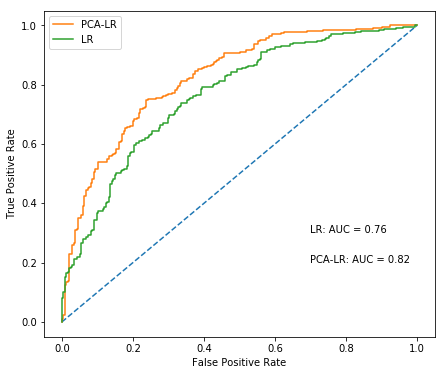

In [19]:
# plot
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], linestyle='--')

# PCA kfold
ax.plot(fprkfoldPCA, tprkfoldPCA, label = 'PCA-LR')
# non PCA kfold
ax.plot(fprkfold, tprkfold, label='LR')

ax.text(0.7, 0.3, 'LR: AUC = '+str(round(acckfold,2)))
ax.text(0.7, 0.2, 'PCA-LR: AUC = '+str(round(acckfoldPCA,2)))

pyplot.legend(loc='best')  
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")

The expected ROC plot is shown below. We see a 6% increase in AUC for LR operating on the 10 PCs compared to the LR operating on 7500 features!

![title](roc_PCALR_vs_LR.png)

**Question 6 (30 points) Compare several classifiers**

Using the $\texttt{cross_validation}$ function implemented above, experiment the following classifiers:

1. LogisticRegression(solver="liblinear")
2. KNeighborsClassifier()
3. SVC(probability=True, gamma='auto')
4. DecisionTreeClassifier()
5. RandomForestClassifier(n_estimators=100)

Note each of the initializers creates a classifier object of the class so that we can pass them to cross_validation function directly without hard coding the specific classifier you want to use inside the function.

Experiment each of the five method with and without 10-PC PCA transformation. Therefore, in total there are **10 methods** to evaluate.

Use the same 5-fold cross-validation to get the ROC and AUC for each method and plot them in a single plot for comparison.

It will take 2-5 minutes to complete all cross validations depending on your computer speed.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


lr = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
svm = SVC(probability=True, gamma='auto')
tree = DecisionTreeClassifier()
forest = RandomForestClassifier(n_estimators=100)

# lr
true_labelslr, pred_scoreslr = cross_validate(lr, X_flat, Y)
fprlr, tprlr, thresholdslr = roc_curve(true_labelslr,pred_scoreslr)
acclr= roc_auc_score(true_labelslr, pred_scoreslr)

# lr PCA
true_labelslrpca, pred_scoreslrpca = cross_validate(lr, X_flat, Y, True)
fprlrpca, tprlrpca, thresholdslrpca = roc_curve(true_labelslrpca,pred_scoreslrpca)
acclrpca= roc_auc_score(true_labelslrpca, pred_scoreslrpca)

# knn
true_labelsknn, pred_scoresknn = cross_validate(knn, X_flat, Y)
fprknn, tprknn, thresholdsknn = roc_curve(true_labelsknn,pred_scoresknn)
accknn= roc_auc_score(true_labelsknn, pred_scoresknn)

# knn PCA
true_labelsknnpca, pred_scoresknnpca = cross_validate(knn, X_flat, Y, True)
fprknnpca, tprknnpca, thresholdsknnpca = roc_curve(true_labelsknnpca,pred_scoresknnpca)
accknnpca= roc_auc_score(true_labelsknnpca, pred_scoresknnpca)

# svm
true_labelssvm, pred_scoressvm = cross_validate(svm, X_flat, Y)
fprsvm, tprsvm, thresholdssvm = roc_curve(true_labelssvm,pred_scoressvm)
accsvm= roc_auc_score(true_labelssvm, pred_scoressvm)

# svm PCA 
true_labelssvmpca, pred_scoressvmpca = cross_validate(svm, X_flat, Y, True)
fprsvmpca, tprsvmpca, thresholdssvmpca = roc_curve(true_labelssvmpca,pred_scoressvmpca)
accsvmpca= roc_auc_score(true_labelssvmpca, pred_scoressvmpca)

# tree
true_labelstree, pred_scorestree = cross_validate(tree, X_flat, Y)
fprtree, tprtree, thresholdstree = roc_curve(true_labelstree,pred_scorestree)
acctree= roc_auc_score(true_labelstree, pred_scorestree)

# tree PCA 
true_labelstreepca, pred_scorestreepca = cross_validate(tree, X_flat, Y, True)
fprtreepca, tprtreepca, thresholdstreepca = roc_curve(true_labelstreepca,pred_scorestreepca)
acctreepca= roc_auc_score(true_labelstreepca, pred_scorestreepca)

# forest
true_labelsforest, pred_scoresforest = cross_validate(forest, X_flat, Y)
fprforest, tprforest, thresholdsforest = roc_curve(true_labelsforest,pred_scoresforest)
accforest= roc_auc_score(true_labelsforest, pred_scoresforest)

# forest PCA
true_labelsforestpca, pred_scoresforestpca = cross_validate(forest, X_flat, Y, True)
fprforestpca, tprforestpca, thresholdsforestpca = roc_curve(true_labelsforestpca,pred_scoresforestpca)
accforestpca= roc_auc_score(true_labelsforestpca, pred_scoresforestpca)

Plot ROC curve in a single plot.

To avoid cluterring, use the following abbreviations the represent each method:

"LogisticRegression":"LR"<br>
"KNeighborsClassifier":"KNN"<br>
"SVC":"SVC"<br>
"DecisionTreeClassifier":"DT"<br>
"RandomForestClassifier":"RF"<br>

For method use PCA, append string "+PCA" their model names. See the expected output plot below.

Text(0,0.5,'True Positive Rate')

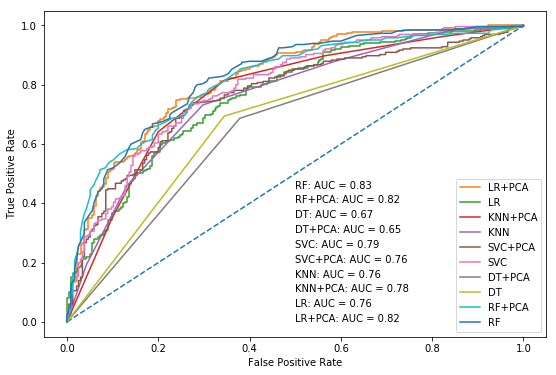

In [22]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], linestyle='--')

ax.plot(fprlrpca, tprlrpca,label='LR+PCA')
ax.plot(fprlr, tprlr,label='LR')
ax.plot(fprknnpca, tprknnpca,label='KNN+PCA')
ax.plot(fprknn, tprknn,label='KNN')
ax.plot(fprsvmpca, tprsvmpca,label='SVC+PCA')
ax.plot(fprsvm, tprsvm,label='SVC')
ax.plot(fprtreepca, tprtreepca,label='DT+PCA')
ax.plot(fprtree, tprtree,label='DT')
ax.plot(fprforestpca, tprforestpca,label='RF+PCA')
ax.plot(fprforest, tprforest,label='RF')

ax.text(0.5, 0,'LR+PCA: AUC = '+str(round(acclrpca,2)))
ax.text(0.5, 0.05,'LR: AUC = '+str(round(acclr,2)))
ax.text(0.5, 0.1,'KNN+PCA: AUC = '+str(round(accknnpca,2)))
ax.text(0.5, 0.15,'KNN: AUC = '+str(round(accknn,2)))
ax.text(0.5, 0.2,'SVC+PCA: AUC = '+str(round(accsvmpca,2)))
ax.text(0.5, 0.25,'SVC: AUC = '+str(round(accsvm,2)))
ax.text(0.5, 0.3,'DT+PCA: AUC = '+str(round(acctreepca,2)))
ax.text(0.5, 0.35,'DT: AUC = '+str(round(acctree,2)))
ax.text(0.5, 0.40,'RF+PCA: AUC = '+str(round(accforestpca,2)))
ax.text(0.5, 0.45,'RF: AUC = '+str(round(accforest,2)))

pyplot.legend(loc='best')    
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")

The expected plot is displayed below.

![title](roc_method_comparisons.png)

As we can see not that all of the methods significantly benefit from PCA transformation. Some of the reasons are: 
* Some of the methods themselves have built-in feature selection algorithm such as RF and DT instead of trying to fit all of the features as in the LR
* SVC transforms the data to hyperplane which is linearly separaable and often do not benefit from external PCA transformation

The best we obtain from this analysis is: *Random Forest* (RF) without PCA transformation with AUC = 0.82 or 0.83 and LR with PCA transformation AUC = 0.82

We will use RF to compare with a convolutional neural network in the bonus question below.

**Bonus (10 points) Running Convoluational Neural Network (CNN) with Keras**

Until now, we treat the image features as flat independent 7500 features. However, images have spatial information in them. For instance, pixels adjacent to each other tend to look more similar than those that are far apart. 

We would like to move an imaginary lense across the image and extract meaningful image features to help classify breast cancer samples.

To this end, we will use *Convoluational Neural Network* (CNN). CNN is a member of the Deep Learning model family that specifically suitable for image inputs. 

![title](Deep_Convolutional_Neural_Networks_for_Breast_Canc.jpg)

The above figure was extracted from the following paper: 
https://arxiv.org/abs/1802.00752

We will use Keras to train a CNN. Keras is a high-level wrapper library of Google TensorFlow and provide simpler API for training neural network with customized architectures. When running on a GPU computer, Keras/TensorFlow will automatically use the GPU for the computing without additional efforts to configure it.

Feel free to compare the performance speeds on a GPU-enabled computer (e.g., one of those gaming desktops/laptops) versus a CPU-only computer.

Our CNN will not be as "deep" as the one shown above in terms of the number of network layers because that will take long time to run.

In [22]:
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [23]:
def trainCNN(x_train, y_train):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    num_classes = 2

    img_rows, img_cols = x_train.shape[1],x_train.shape[2]            
    
    input_shape = (img_rows, img_cols, 3)

    model = Sequential()        
    
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images    
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    model.fit_generator(datagen.flow(x_train, y_train,batch_size=32),
                        steps_per_epoch=len(x_train) / 32, 
                        epochs=12,
                        verbose=1)
        
    return model

Building the CNN model is sequential which allows us to create it layer-by-layer. The architecture consists of two convolutional layers, one max pooling layer, one dropout layer, one flatten layer (2D to 1D), one fully connected layers, anotehr dropout layer, and finally the output layer with sigmoid activation output unit for prediction.

We also include a data augmentation step to learn rotation and translation invariant features

Let's load the full data of 5547 images and labels

In [24]:
X = np.load('X.npy')/256.0
Y = np.load('Y.npy')

print(X.shape) # (5547, 50, 50, 3)
print(Y.shape) # (5547,)

(5547, 50, 50, 3)
(5547,)


Implement the cross validation for the CNN model. 

Different from cross_validate implemented in Q5, we need to use one-hot encoding to formulate Y into a two-column binary matrix (i.e., $5547\times 2$) with the first column indicating IDC(-) and second column indicating IDC(+).

You can use the function to_categorical(Y, num_classes=2) to do this

In [25]:
def cross_validate_cnn(X, Y):
    
    # YOUR CODE HERE
    
    return (true_labels, pred_scores)    

Let's do a 5-fold CV on the CNN model using all of the 5000 images. This will 1-8 hours depending on your computer.

In [26]:
true_labels,pred_scores = cross_validate_cnn(X, Y)

Let's plot the ROC based on the 5-fold cross validation results on the CNN. This will 1-8 hours depending on your computer especially whether it has a GPU or not.

In [27]:
# YOUR CODE HERE

The expected plot is display below. 

We see that the CNN we trained above is not as good as RF or LR+PCA (besides taking much longer to train).

Training deep neural network requires a lot of data points and a lot of engineering of the model parameters and architectures. 

There are efficient automated ways to alleviate some of the manual tunings. See this guide (https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/) 

Play around with various architectures and settings to see whether you can improve it.

![title](roc_CNN.png)

### Reference: ###

For more information about the data, see https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872.

For more information about IDC and breast cancer, please review the following publications: 
* https://www.ncbi.nlm.nih.gov/pubmed/27864452
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3893344/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4952020/
* https://arxiv.org/abs/1802.00752 (Deep learning approach)